In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as Fun
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# try running the following code, if you see errors on Windows OS
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

In [3]:
import pandas as pd
import numpy as np

# File to Load (Remember to Change These)
file_to_load = "Data\Steel_industry_data.csv"

# Read Purchasing File and store into Pandas data frame
steel_csv = pd.read_csv(file_to_load)
steel_csv.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


## Data

In [4]:
steel_csv.Load_Type.replace(('Medium_Load', 'Light_Load', 'Maximum_Load'),(1, 0, 2), inplace=True)
steel_csv.Day_of_week.replace(('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'),(1, 2, 3, 4, 5, 6, 7), inplace=True)
steel_csv.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,1,0
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,1,0
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,1,0
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,1,0
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,1,0


In [5]:
cols=[x for i,x in enumerate(steel_csv.columns) if steel_csv.iat[0,i]=='Weekend']
steel_weekday=steel_csv.drop(cols,axis=1)
steel_weekday

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.00,0.0,73.21,100.00,900,Weekday,1,0
1,01/01/2018 00:30,4.00,4.46,0.00,0.0,66.77,100.00,1800,Weekday,1,0
2,01/01/2018 00:45,3.24,3.28,0.00,0.0,70.28,100.00,2700,Weekday,1,0
3,01/01/2018 01:00,3.31,3.56,0.00,0.0,68.09,100.00,3600,Weekday,1,0
4,01/01/2018 01:15,3.82,4.50,0.00,0.0,64.72,100.00,4500,Weekday,1,0
...,...,...,...,...,...,...,...,...,...,...,...
35035,31/12/2018 23:00,3.85,4.86,0.00,0.0,62.10,100.00,82800,Weekday,1,0
35036,31/12/2018 23:15,3.74,3.74,0.00,0.0,70.71,100.00,83700,Weekday,1,0
35037,31/12/2018 23:30,3.78,3.17,0.07,0.0,76.62,99.98,84600,Weekday,1,0
35038,31/12/2018 23:45,3.78,3.06,0.11,0.0,77.72,99.96,85500,Weekday,1,0


In [6]:
steel_csv=steel_csv.drop(['NSM','WeekStatus','Day_of_week'],axis=1)

In [7]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
mms.fit(steel_csv.iloc[:-800][['Usage_kWh','Lagging_Current_Reactive.Power_kVarh','Leading_Current_Reactive_Power_kVarh','CO2(tCO2)','Lagging_Current_Power_Factor','Leading_Current_Power_Factor','Load_Type']])
steel_csv[['Usage_kWh','Lagging_Current_Reactive.Power_kVarh','Leading_Current_Reactive_Power_kVarh','CO2(tCO2)','Lagging_Current_Power_Factor','Leading_Current_Power_Factor','Load_Type']] = mms.transform(steel_csv[['Usage_kWh','Lagging_Current_Reactive.Power_kVarh','Leading_Current_Reactive_Power_kVarh','CO2(tCO2)','Lagging_Current_Power_Factor','Leading_Current_Power_Factor','Load_Type']])

In [8]:
X = []
y = []
for i in range(36, len(steel_csv)):
    X.append(steel_csv.iloc[i-36:i, 1:8].values)  # 输入数据未取到i时刻
    y.append(steel_csv.iloc[i, 1])  # 标签数据为i时刻
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float).view(-1, 1)
X.shape, y.shape

(torch.Size([35004, 36, 7]), torch.Size([35004, 1]))

In [9]:
N = -8000
X_train, X_test = X[:N], X[N:]
y_train, y_test = y[:N], y[N:]
trainloader = DataLoader(TensorDataset(X_train, y_train), 64, True)
X_train.shape, X_test.shape

(torch.Size([27004, 36, 7]), torch.Size([8000, 36, 7]))

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## DNN

In [11]:
lr=0.001

In [12]:
class ModelDNN(nn.Module):
    def __init__(self, input_size, hiddens=[512, 256, 128]):
        super().__init__()
        self.hiddens = hiddens
        self.net = nn.Sequential(nn.Flatten())
        for pre, nxt in zip([input_size]+hiddens[:-1], hiddens):
            self.net.add_module(str(len(self.net)),nn.Linear(pre, nxt))
            self.net.add_module(str(len(self.net)),nn.ReLU())
        self.net.add_module(str(len(self.net)),nn.Linear(hiddens[-1], 1))
        
    def forward(self, x):
        return self.net(x)


In [13]:
modelDNN = ModelDNN(36*7).to(device)
optimizer = torch.optim.Adam(modelDNN.parameters(),lr=lr)
criterion = nn.MSELoss()

In [14]:
for i in range(60):
    for X, y in trainloader:
        y_pred = modelDNN(X.to(device))
        loss = criterion(y_pred, y.to(device))*150*150
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (i+1) % 10 ==0:
        with torch.no_grad():
            train_pred = modelDNN(X_train.to(device))
            train_mse = criterion(train_pred.to(device), y_train.to(device))
            test_pred = modelDNN(X_test.to(device))
            test_mse = criterion(test_pred, y_test.to(device))
            print(i, train_mse.item(), test_mse.item())

9 0.00427401764318347 0.003872014582157135
19 0.004184735473245382 0.004166178405284882
29 0.0037668058648705482 0.0037093530409038067
39 0.0035317849833518267 0.0035971137695014477
49 0.003456160658970475 0.0034227673895657063
59 0.0035443813540041447 0.0036811840254813433


In [15]:
torch.save(modelDNN,"modelDNN.pth")

R2= 0.9115579248501658 
RMSE 0.06067276


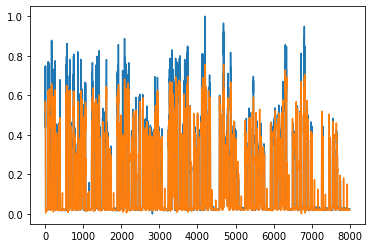

In [16]:
DNNpred=modelDNN(X_test.to(device)).cpu().detach().numpy()

plt.plot(y_test)
plt.plot(DNNpred)
#R2=sum(y_test*y_test-DNNpred*DNNpred)/N
R2=r2_score(y_test,DNNpred)
MSE=mean_squared_error(y_test,DNNpred)
RMSE=np.sqrt(MSE)
print('R2=',R2,'\nRMSE',RMSE)

## RNN

In [17]:
class ModelRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # 注意，这里设置batch_first=True
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.activation = nn.ReLU()
        self.output = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        _, hidden = self.gru(x)
        hidden = hidden.squeeze(0)
        hidden = self.activation(hidden)
        return self.output(hidden)

In [18]:
modelRNN = ModelRNN(7, 32).to(device)
optimizer = torch.optim.Adam(modelRNN.parameters())
criterion = nn.MSELoss()

for i in range(80):
    for X, y in trainloader:
        y_pred = modelRNN(X.to(device))
        loss = criterion(y_pred, y.to(device))*150*150
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (i+1) % 10 ==0:
        with torch.no_grad():
            train_pred = modelRNN(X_train.to(device))
            train_mse = criterion(train_pred, y_train.to(device))
            test_pred = modelRNN(X_test.to(device))
            test_mse = criterion(test_pred, y_test.to(device))
            print(i, train_mse.item(), test_mse.item())

9 0.005454970058053732 0.00471925176680088
19 0.0050100767984986305 0.004327598959207535
29 0.0046974048018455505 0.004206503741443157
39 0.004424830432981253 0.004271280486136675
49 0.004067528527230024 0.0039223372004926205
59 0.003935033455491066 0.003686195006594062
69 0.003764738328754902 0.003619471797719598
79 0.0037401574663817883 0.0037211377639323473


In [19]:
torch.save(modelRNN,"modelRNN.pth")

R2= 0.9105980231687433 
RMSE 0.061001126


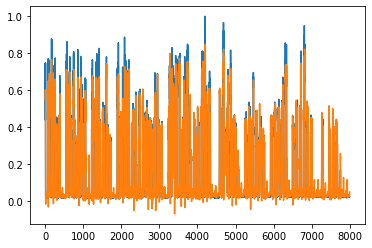

In [20]:
RNNpred=modelRNN(X_test.to(device)).cpu().detach().numpy()

plt.plot(y_test)
plt.plot(RNNpred)
#R2=sum(y_test*y_test-DNNpred*DNNpred)/N

R2=r2_score(y_test,RNNpred)
MSE=mean_squared_error(y_test,RNNpred)
RMSE=np.sqrt(MSE)
print('R2=',R2,'\nRMSE',RMSE)